In [88]:
import importlib
import random
import pathlib
import os
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import PIL
import skimage
from skimage import exposure, img_as_float
import cv2
import tensorflow as tf

In [2]:
%matplotlib inline

In [55]:
def select_objects(indexes_list, objects_names):
    return tuple(objects_names[i] for i in indexes_list)

In [47]:
def select_random_indexses_subset(size, subset_size):
    return random.sample(tuple(range(size)), subset_size)

In [48]:
def random_objects_select(objects_names, subset_size):
    objects_names_len = len(objects_names)
    indexes = select_random_indexses_subset(objects_names_len, subset_size)
    return select_objects(indexes, objects_names)

In [79]:
def compute_whole_image_mean_brightnes(image):
    return image.mean()

In [10]:
def show_images_grid(images_list, columns_num, figsize, images_names_list=None):
    rows_num = len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_names_list_slices = []
    images_list_slices = [
        images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    if images_names_list:
        images_names_list_slices = [
            images_names_list[i * slice_len:(i+1) * slice_len]\
            for i in range(images_list_slices_len)
        ]
    #print("show_images_grid, images_names_list_slices:\n", images_names_list_slices)
    for i in range(ax.shape[0]):
        images_list_slice = images_list_slices[i]
        images_names_list_slice = []
        if images_names_list:
            images_names_list_slice = images_names_list_slices[i]
        #images_list_0 = [images_pair[0] for images_pair in paired_images_list_slice]
        #images_list_1 = [images_pair[1] for images_pair in paired_images_list_slice]
        for j in range(columns_num):
            if images_names_list:
                #print("show_images_grid, images_names_list_slice[{}]:\n".format(j), images_names_list_slice[j])
                ax[i, j].set_title(images_names_list_slice[j])            
            ax[i, j].imshow(images_list_slice[j])

            #ax[2 * i + 1, j].imshow(images_list_1[j])
    plt.tight_layout()
    plt.show()

In [75]:
def draw_images_with_histograms(images_list, columns_num, figsize, nbins):
    rows_num = 3 * len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_list_slices = [
    images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    for i in range(ax.shape[0] // 3):
        images_list_slice = images_list_slices[i]
        for j in range(columns_num):
            ax[3 * i, j].imshow(images_list_slice[j])
            ax[3 * i, j].grid(False)
            img_cdf, cdf_bins = exposure.cumulative_distribution(images_list_slice[j].flatten())
            ax[3 * i + 1, j].hist(exposure.histogram(images_list_slice[j].flatten(), nbins=nbins))
            ax[3 * i + 2, j].plot(cdf_bins, img_cdf, color='green')
    plt.show()

In [3]:
ls ../input/

sample_submission.csv  test_images.zip  train.csv.zip  train_images.zip


In [11]:
train_images_dir = '../input/train/'
test_images_dir = '../input/test'

In [14]:
#train_images_names = os.listdir(train_images_dir)
train_images_names = pathlib.Path().glob('../input/train/*')
for img_name in tuple(train_images_names)[:10]:
    print(img_name)

../input/train/5e92f8e11.jpg
../input/train/74cd21b41.jpg
../input/train/3beb63791.jpg
../input/train/af328f32c.jpg
../input/train/9dfd2503e.jpg
../input/train/db4716807.jpg
../input/train/b7688a29f.jpg
../input/train/6eeaaa295.jpg
../input/train/49d6875d0.jpg
../input/train/15f78ae69.jpg


In [6]:
train_df = pd.read_csv('../input/train.csv')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50272 entries, 0 to 50271
Data columns (total 2 columns):
ImageId_ClassId    50272 non-null object
EncodedPixels      7095 non-null object
dtypes: object(2)
memory usage: 785.6+ KB


In [8]:
train_df.describe()

,ImageId_ClassId,EncodedPixels
count,50272,7095
unique,50272,7095
top,5574a47da.jpg_2,931 66 1179 77 1427 89 1675 100 1923 111 2171 ...
freq,1,1


In [9]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [34]:
#image_ids_and_class_ids = train_df['ImageId_ClassId'].map(lambda x: x.split('_'))

In [35]:
#type(image_ids_and_class_ids)

In [36]:
#image_ids_and_class_ids.head()

In [22]:
type(image_ids_and_class_ids[0])

list

In [30]:
# image_descriptions_df = pd.DataFrame(
#     {'image_id': image_ids_and_class_ids[:][0], 'class_id': image_ids_and_class_ids[:][1]})

In [37]:
#image_descriptions_df.head()

In [32]:
image_descriptions_list = [row.split('_') for row in train_df['ImageId_ClassId']]

In [33]:
image_descriptions_list[:10]

[['0002cc93b.jpg', '1'],
 ['0002cc93b.jpg', '2'],
 ['0002cc93b.jpg', '3'],
 ['0002cc93b.jpg', '4'],
 ['00031f466.jpg', '1'],
 ['00031f466.jpg', '2'],
 ['00031f466.jpg', '3'],
 ['00031f466.jpg', '4'],
 ['000418bfc.jpg', '1'],
 ['000418bfc.jpg', '2']]

In [53]:
train_image_names = [image_name for image_name, _ in image_descriptions_list]
len(train_image_names)

50272

In [42]:
train_image_names[:4]

['0002cc93b.jpg', '0002cc93b.jpg', '0002cc93b.jpg', '0002cc93b.jpg']

In [44]:
#full_image_path = pathlib.Path.joinpath(pathlib.Path(train_images_dir), pathlib.Path(train_image_names[0]))

In [54]:
#full_image_path.as_posix()

In [46]:
train_images_dict = {
    image_name: cv2.imread(os.path.join(train_images_dir, image_name)) for image_name in train_image_names
}

In [69]:
train_images_num = train_df.shape[0]
train_images_names_sample = random_objects_select(tuple(train_image_names), int(train_images_num / 4))
print(type(train_images_names_sample))
print(train_images_names_sample[:5])

<class 'tuple'>
('19e9bfbf2.jpg', '3a6a4078f.jpg', '14b5ab5a6.jpg', '3116edfe6.jpg', '0c6b1cfeb.jpg')


In [57]:
train_images = tuple(train_images_dict.values())

In [73]:
#train_images[0]

In [60]:
images_subsample = [train_images_dict[img_name] for img_name in train_images_names_sample[:40]]

In [71]:
#images_subsample = [train_images_dict[img_name] for img_name in image_names_subsample]

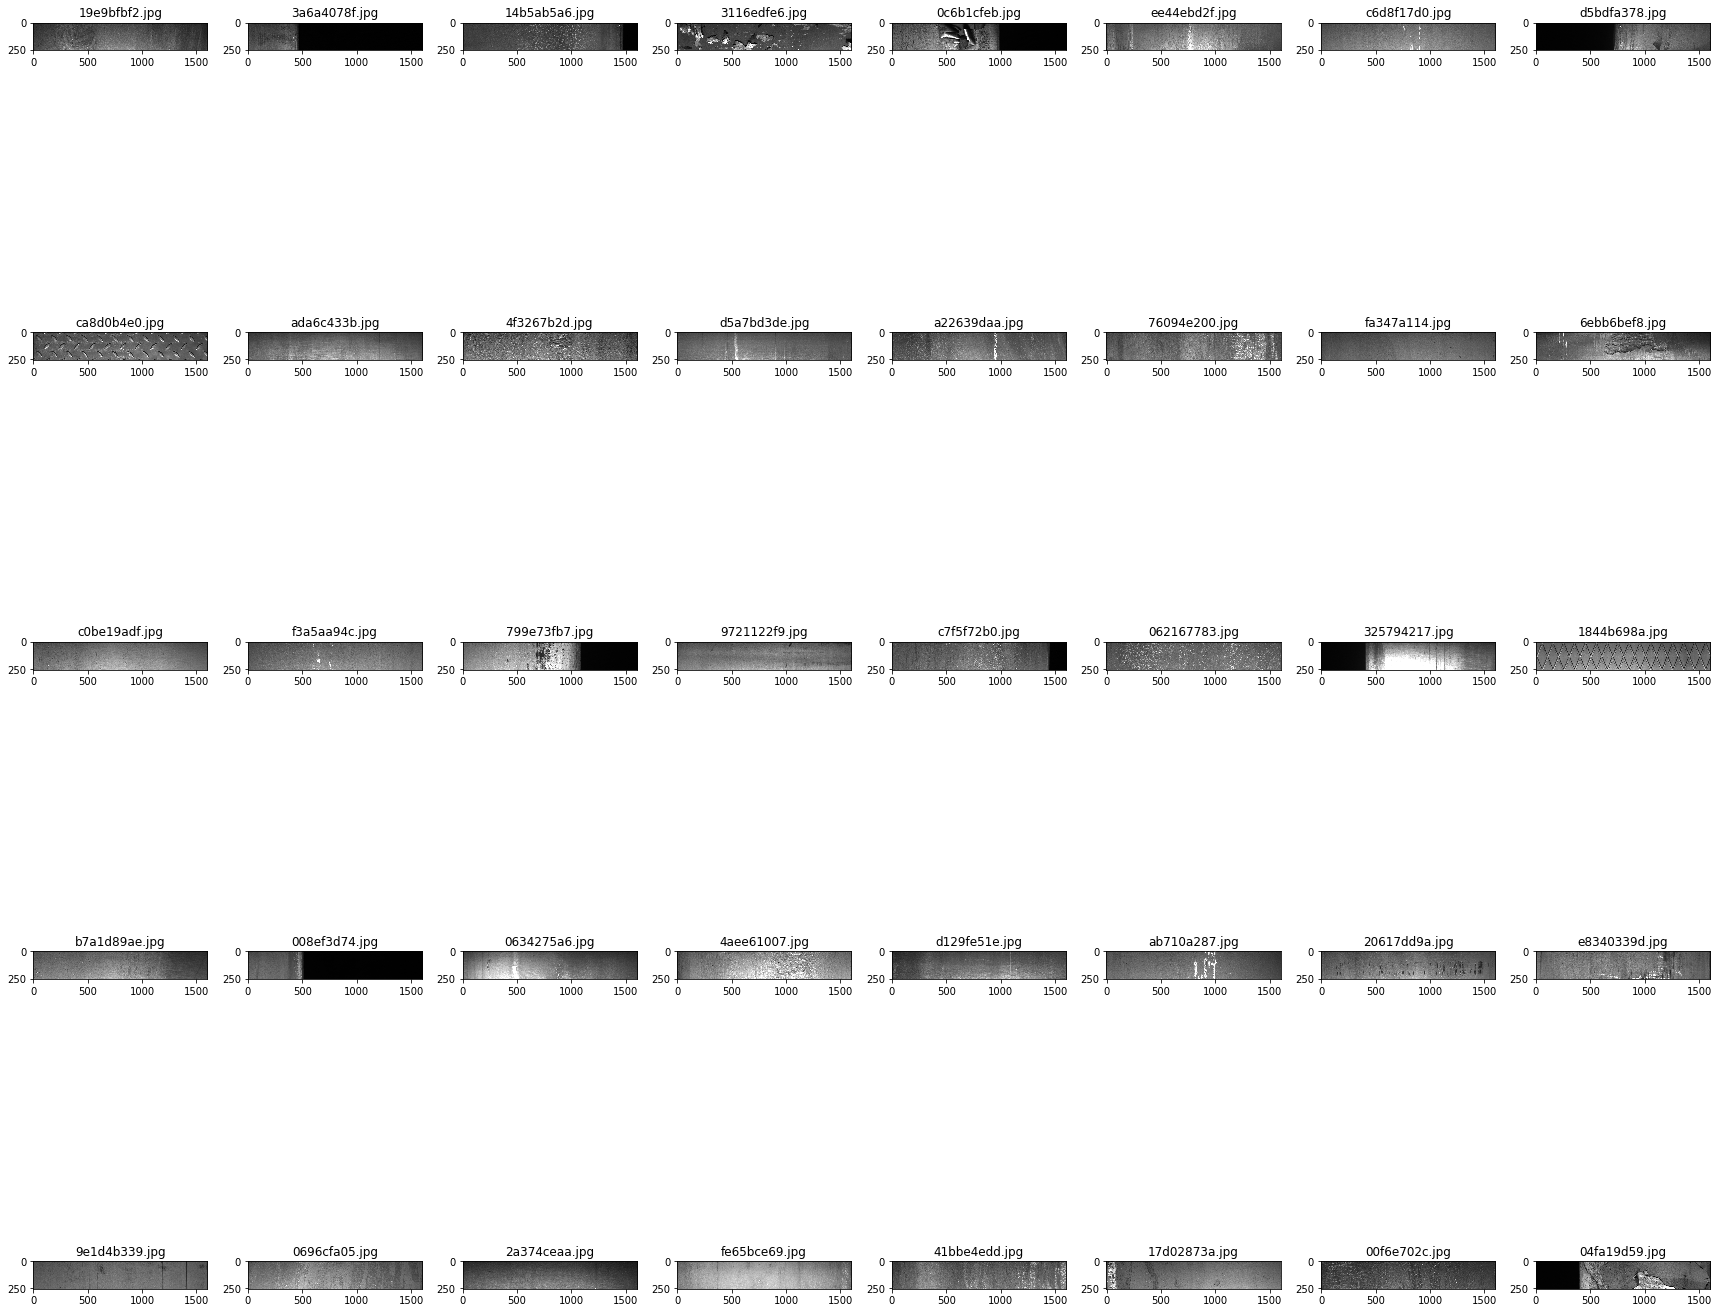

In [72]:
show_images_grid(images_subsample, 8, (24, 24), images_names_list=train_images_names_sample[:40])

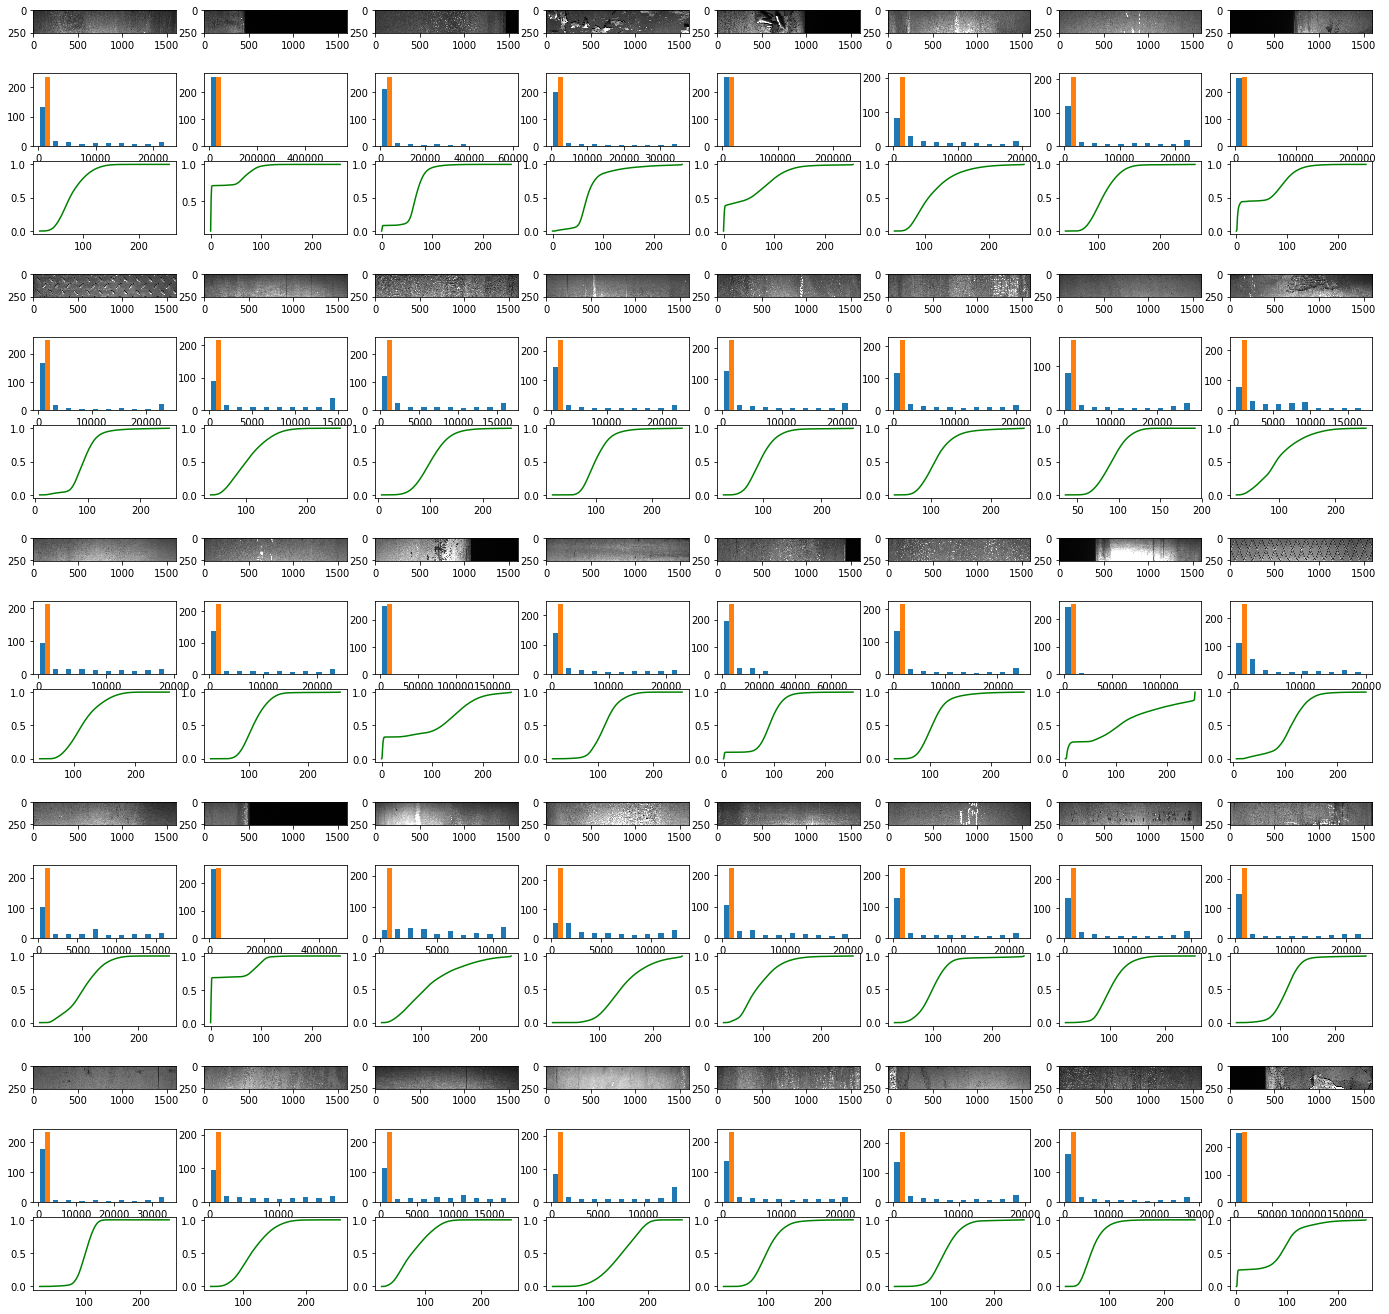

In [78]:
draw_images_with_histograms(images_subsample, 8, (24, 24), 20)

In [80]:
train_images_mean_brightness = [
    compute_whole_image_mean_brightnes(image) for image in train_images
]

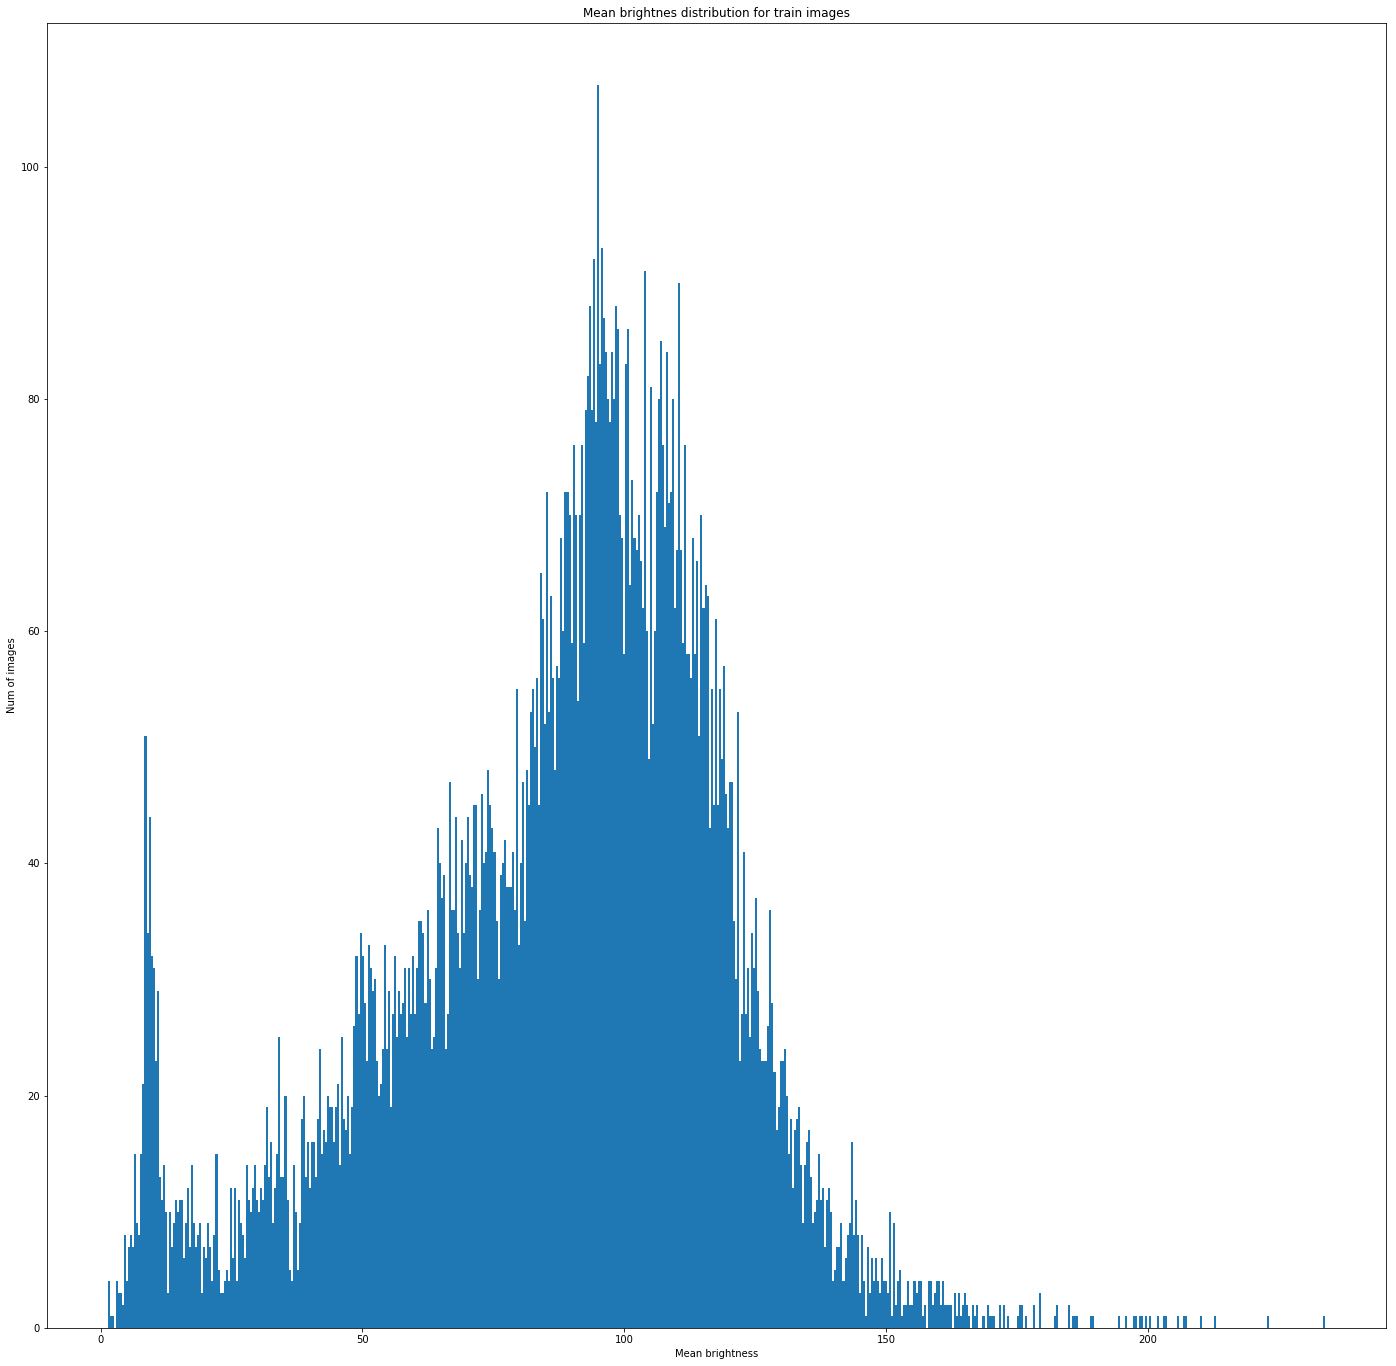

In [82]:
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(train_images_mean_brightness, bins=600)
ax.set_title("Mean brightnes distribution for train images")
#ax.set(title="Mean brightnes distribution for images with chips")
ax.set_xlabel("Mean brightness")
ax.set_ylabel("Num of images")
plt.show()

In [84]:
print(min(train_images_mean_brightness))
print(max(train_images_mean_brightness))

1.41866455078125
233.9423095703125


In [85]:
print(len(train_images_mean_brightness))

12568


In [86]:
set_train_images_mean_brightness = set(train_images_mean_brightness)

In [87]:
print(len(set_train_images_mean_brightness))

12564


In [89]:
n_inputs = 1600 * 250
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 5

In [90]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None, ), name='y')

In [91]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')